In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
import lightgbm as lgb
import numpy as np

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [2]:
train = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')

def explore_df(df):
    display(df.head())
    display(pd.DataFrame({
        'dtype': df.dtypes,
        'n_missing': df.isna().sum(),
        'pct_missing': df.isna().mean() * 100,
        'n_unique': df.nunique()
    }).sort_values(by='n_missing', ascending=False))
    print('Shape:', df.shape)
    print('Duplicated rows:', df.duplicated().sum())

In [3]:
explore_df(train)

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


,dtype,n_missing,pct_missing,n_unique
bid_qty,float64,0,0.0,45801
ask_qty,float64,0,0.0,46819
X586,float64,0,0.0,469391
X587,float64,0,0.0,523633
X588,float64,0,0.0,500337
...,...,...,...,...
X298,float64,0,0.0,525887
X299,float64,0,0.0,525887
X300,float64,0,0.0,525887
X301,float64,0,0.0,525887


Shape: (525887, 896)
Duplicated rows: 0


In [4]:
X_cols = [col for col in train.columns if col.startswith('X')]
df_stats = train[X_cols].agg(['mean', 'std', 'min', 'max']).T
df_stats.sort_values(by='std', ascending=False).head(20)

,mean,std,min,max
X487,0.007512,1.197317,-4.344772e+01,34.238382
X494,0.007498,1.194346,-4.304424e+01,33.892267
X492,0.001222,1.160042,-4.369558e+01,44.467605
X485,0.002263,1.155616,-4.494001e+01,44.538918
X536,0.108826,1.136846,-1.113484e+01,15.394453
X666,0.574239,1.132714,3.679951e-03,34.391372
X569,0.026289,1.107013,-2.144256e+01,21.024427
X526,-0.108724,1.104513,-1.603182e+01,9.445013
X648,0.059800,1.093803,3.265679e-16,222.024456
X618,0.070812,1.090494,1.221487e-87,181.818219


In [5]:
corrs = train[X_cols + ['label']].corr()['label'].drop('label')
corrs.abs().sort_values(ascending=False).head(20)

X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
X19     0.062293
X27     0.062251
X22     0.057676
X858    0.057320
X219    0.056713
X860    0.056259
X531    0.056184
X287    0.055893
X289    0.055892
X291    0.055435
X293    0.055291
X857    0.054686
X295    0.054637
X598    0.054528
X218    0.053676
Name: label, dtype: float64

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

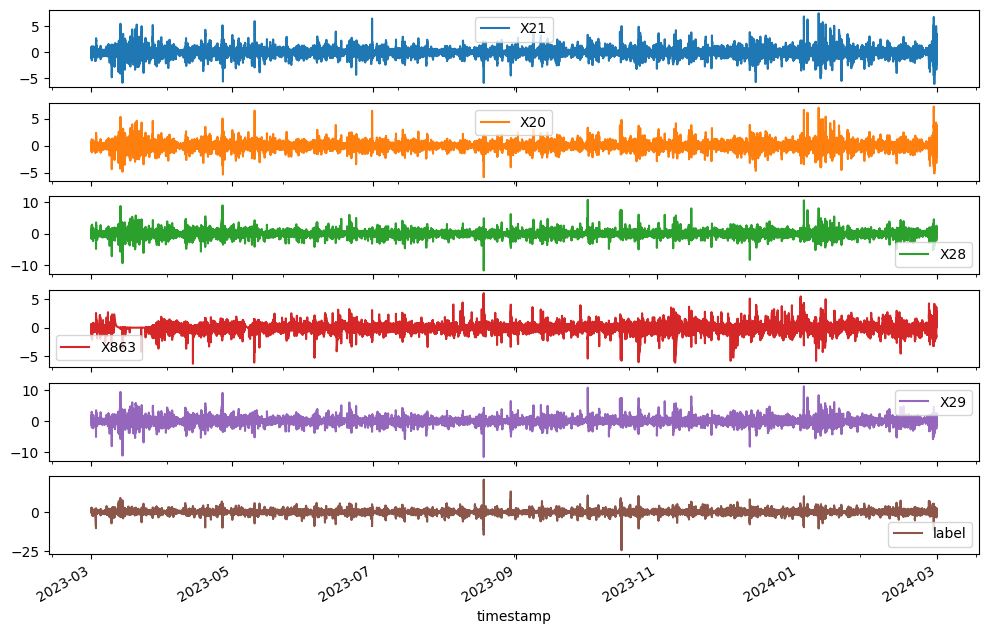

In [6]:
top_corr_cols = corrs.abs().sort_values(ascending=False).head(5).index.tolist()
train[top_corr_cols + ['label']].plot(subplots=True, figsize=(12, 8))


In [9]:
train[X_cols].describe().T[['mean', 'std', 'min', 'max']].sort_values(by='max', ascending=False).head(10)


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:465

,mean,std,min,max
X873,0.537144,1.025948,3.664396e-02,259.109312
X648,0.059800,1.093803,3.265679e-16,222.024456
X618,0.070812,1.090494,1.221487e-87,181.818219
X624,0.053227,1.064180,1.890226e-88,181.818219
X231,-0.133070,0.863670,-6.897447e+00,134.768594
X636,0.023732,0.699803,9.851429e-33,129.032651
X630,0.085529,0.827160,9.192662e-32,129.032651
X230,-0.116586,0.943515,-1.183191e+01,128.967127
X595,0.055877,0.697336,0.000000e+00,121.130381
X236,-0.000168,0.876276,-8.732988e+01,116.197900


In [10]:
sampled = train[X_cols].sample(10000, random_state=42)
corr_matrix = sampled.corr().abs()
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = (corr_matrix.where(upper) > 0.98).stack()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [11]:
valid_cols = train[X_cols].loc[:, train[X_cols].std() > 0.00001].columns
sampled = train[valid_cols].sample(10000, random_state=42)
corr_matrix = sampled.corr().abs()
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = corr_matrix.where(upper).stack().loc[lambda x: x > 0.98]


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [12]:
useful_features = corrs.abs().sort_values(ascending=False).head(100).index.tolist()


In [13]:
X = train[useful_features]
y = train['label']


In [14]:
tscv = TimeSeriesSplit(n_splits=5)


In [15]:
def pearson_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

In [16]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    score = pearson_corr(y_val, y_pred)
    print(f'Fold {fold+1}: Pearson correlation = {score:.5f}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 87652, number of used features: 100
[LightGBM] [Info] Start training from score 0.029379
Fold 1: Pearson correlation = 0.10580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175299, number of used features: 100
[LightGBM] [Info] Start training from score 0.020700
Fold 2: Pearson correlation = 0.09512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

In [17]:
test = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')
sample_submission = pd.read_csv('/kaggle/input/drw-crypto-market-prediction/sample_submission.csv')
X_test = test[useful_features]
y_pred_test = model.predict(X_test)


In [19]:
submission = sample_submission.copy()
submission['label'] = y_pred_test
submission.to_csv('/kaggle/working/submission.csv', index=False)



In [23]:
submission = pd.DataFrame({
    'ID': sample_submission['ID'],
    'prediction': y_pred_test
})
submission.to_csv('/kaggle/working/submission.csv', index=False)


(538150, 2)